In [ ]:
import sys
sys.path.append('../')

import numpy as np
import networkx as nx
import itertools
import torch
import torch.nn.functional as F
import torch_sparse
import random 
import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn
from models.sheaf_base import SheafDiffusion
from models.cont_models import GraphLaplacianDiffusion, DiagSheafDiffusion
from lib.laplace import get_1d_oracle_maps
from torch_geometric.nn.dense.linear import Linear
from scipy import linalg
from data.heterophilic import generate_random_splits
from torch_geometric.utils import to_dense_adj, from_networkx
from torch_geometric.nn.conv import GCNConv
from models import laplacian_builders as lb
from torchdiffeq import odeint
from torchdiffeq import odeint_adjoint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)

import matplotlib as mpl
sns.set(font_scale=1.3)  

%load_ext autoreload
%autoreload 2

In [ ]:
args = {
    'hidden_channels': 10,
    'layers': -1,
    'device': torch.device('cpu'),
    'normalised': True,
    'deg_normalised': False,
    'linear': True,
    'input_dropout': 0.0,
    'dropout': 0.0,
    'left_weights': False,
    'right_weights': False,
    'use_act': False,
    'second_linear': False,
    'add_lp': False,
    'add_hp': False,
    'sheaf_act': 'tanh',
    'tol_scale': 1.0,
    'int_method': 'dopri5',
    'step_size': None,
    'max_iters': None,
    'tol_scale_adjoint': 1.0,
    'adjoint_method': 'euler',
    'adjoint_step_size': None,
    'edge_weights': False,
    'orth': 'householder',
    'd': 1,
    'adjoint': False,
    'graph_size': data.num_nodes,
    'input_dim': 5,
    'output_dim': 2,
}

Go through every available seed.

In [171]:
os.listdir('./exp/results/QM9-cwn')
os.path.isdir('./exp/results/QM9-cwn')

True

In [203]:
# path_to_results = "./exp/results/"
# dataset = "QM9"

path_to_results = "./exp/results/"
dataset = "QM9"

# e.g. models = ['QM9-cwn', 'QM9-gcwn-equiv', 'QM9-gcwn']
models = []
for dataset_model_dir in os.listdir(path_to_results):
    path_dataset_model = path_to_results + dataset_model_dir
    if os.path.isdir(path_dataset_model) and dataset_model_dir.startswith(dataset + "-"):
        models.append(dataset_model_dir)


# e.g. seed_curves["QM9-cwn"][2]["train"] =  [0.35, 0.23, ...] where seed=2    
seed_curves = {}
for model in models:
    path_to_model_results = path_to_results + model
#     print(path_to_model_results)
    
    seed_dirs = [item for item in os.listdir(path_to_model_results) if os.path.isdir(os.path.join(path_to_model_results, item))]
    
    seed_curves[model] = []
    for seed in seed_dirs:
        with open(path_to_model_results + '/' + seed + "/curves.pkl", 'rb') as handle:
            model_seed_data = pickle.load(handle)
            del model_seed_data["train_loss"]
            seed_curves[model].append(model_seed_data)
    
# print(seed_curves.keys())
# print(seed_curves["QM9-cwn"][0].keys())
# print(seed_curves["QM9-cwn"][0]["train"])


# seed_dirs = [item for item in os.listdir(path_to_results) if os.path.isdir(os.path.join(path_to_results, item))]

# seed_dirs

[0.79773796, 0.8002167, 0.79332906, 0.7688425, 0.7242872, 0.66862625, 0.6179628, 0.58078, 0.56424475, 0.54800403, 0.54754657, 0.5417194, 0.5280161, 0.51502657, 0.49926668, 0.49902317, 0.50784266, 0.49294618, 0.51469195, 0.49442184, 0.48002833, 0.48824254, 0.46112296, 0.45949286, 0.46167985, 0.4499339, 0.44289672, 0.436896, 0.42526543, 0.43638837, 0.44618493, 0.43612662, 0.4386941, 0.43761146, 0.41268903, 0.44236988, 0.40217713, 0.40993786, 0.4100263, 0.41636518, 0.37877783, 0.3740152, 0.36504275, 0.36524984, 0.36354083, 0.37071532, 0.35341272, 0.35468704, 0.35393924, 0.35301006, 0.35470054, 0.3538717, 0.36365366, 0.3716222, 0.3402185, 0.34088537, 0.33308977, 0.33067492, 0.33479676, 0.3307215, 0.32542208, 0.33092445, 0.32474983, 0.32561952, 0.32445568, 0.3243241, 0.32151684, 0.31406578, 0.3153935, 0.31254205, 0.311243, 0.31267977, 0.31238514, 0.3100072, 0.3099692, 0.31091666, 0.31033862, 0.3078952]


In [197]:
# import os
# import pickle

# path_to_results = "./exp/results/"
# dataset = "QM9"

# models = []
# for dataset_model_dir in os.listdir(path_to_results):
#     path = os.path.join(path_to_dataset_res, dataset_model_dir)
#     if os.path.isdir(path) and 

# models = [item for item in os.listdir(path_to_dataset_res) if os.path.isdir(os.path.join(path_to_dataset_res, item))]
# print(models)

# seed_dirs = [item for item in os.listdir(path_to_results) if os.path.isdir(os.path.join(path_to_results, item))]

# seed_curves = []
# for seed in seed_dirs:
#     with open(path_to_results + seed + "/curves.pkl", 'rb') as handle:
#         seed_curves.append(pickle.load(handle))

# Aggregate Results

In [100]:
# a = [{"train": [1, 2, 3], ]
print(seed_curves[0].keys())

dict_keys(['train', 'val', 'test', 'last_val', 'last_test', 'last_train', 'best'])


In [244]:
# a = {1:2, 3:4}
# for i in a:
#     print(i)

list(pd.DataFrame([[1, 3, 5], [1, 4]]).mean(axis = 0))
list(pd.DataFrame([[1, 3, 5], [1, 4]]).std(axis = 0))

[0.0, 0.7071067811865476, nan]

In [270]:
# We want mean_std_curves["QM9-cwn"]["train"] = (mean, std)
import pandas as pd

mean_std_curves = {}

def agg_results(res):
    mean = pd.DataFrame(res).mean(axis=0).to_numpy()
    std = pd.DataFrame(res).std(axis=0).fillna(0).to_numpy()
    low_std, above_std = mean - std, mean + std
#     print(mean.shape, low_std.shape)
    return mean, low_std, above_std

train_curves = []
val_curves = []
test_curves = []
for model in seed_curves.keys():
    for curves in seed_curves[model]:
#         print(curves)
        print(model, len(curves["train"]))
        train_curves.append(curves["train"])
        val_curves.append(curves["val"])
        test_curves.append(curves["test"])
    
#     train_curves = torch.tensor(train_curves)
    mean_std_curves[model] = {}
#     print(np.array(train_curves))
    mean_std_curves[model]["train"] = agg_results(train_curves)
    mean_std_curves[model]["val"] = agg_results(val_curves) 
    mean_std_curves[model]["test"] = agg_results(test_curves) 
    
# for curves in seed_curves:
#     train_curves.append(curves["train"])
#     val_curves.append(curves["val"])
#     test_curves.append(curves["test"])

# print(np.array(train_curves).shape)

# np.mean(train_curves, axis=0).shape
# np.std(train_curves, axis=0)


# train_mean, train_std = agg_results(train_curves)
# test_mean, test_std = agg_results(test_curves) 

print(mean_std_curves.keys())
print(mean_std_curves['QM9-cwn'].keys())
print(mean_std_curves[model]["train"][2][-10])

QM9-cwn 78
QM9-cwn 106
(106,) (106,)
(106,) (106,)
(106,) (106,)
QM9-gcwn-equiv 5
QM9-gcwn-equiv 5
(106,) (106,)
(106,) (106,)
(106,) (106,)
QM9-gcwn 106
QM9-gcwn 110
QM9-gcwn 91
QM9-gcwn 105
(110,) (110,)
(110,) (110,)
(110,) (110,)
dict_keys(['QM9-cwn', 'QM9-gcwn-equiv', 'QM9-gcwn'])
dict_keys(['train', 'val', 'test'])
0.26067488810461303


In [204]:
agg_results(train_curves)

(array([0.836432  , 0.7999972 , 0.7794136 , 0.7324914 , 0.67875236],
       dtype=float32),
 array([0.02603617, 0.00754651, 0.02335188, 0.02354029, 0.0111165 ],
       dtype=float32))

In [275]:
mean_std_curves[model]["train"][0].shape

(106,)

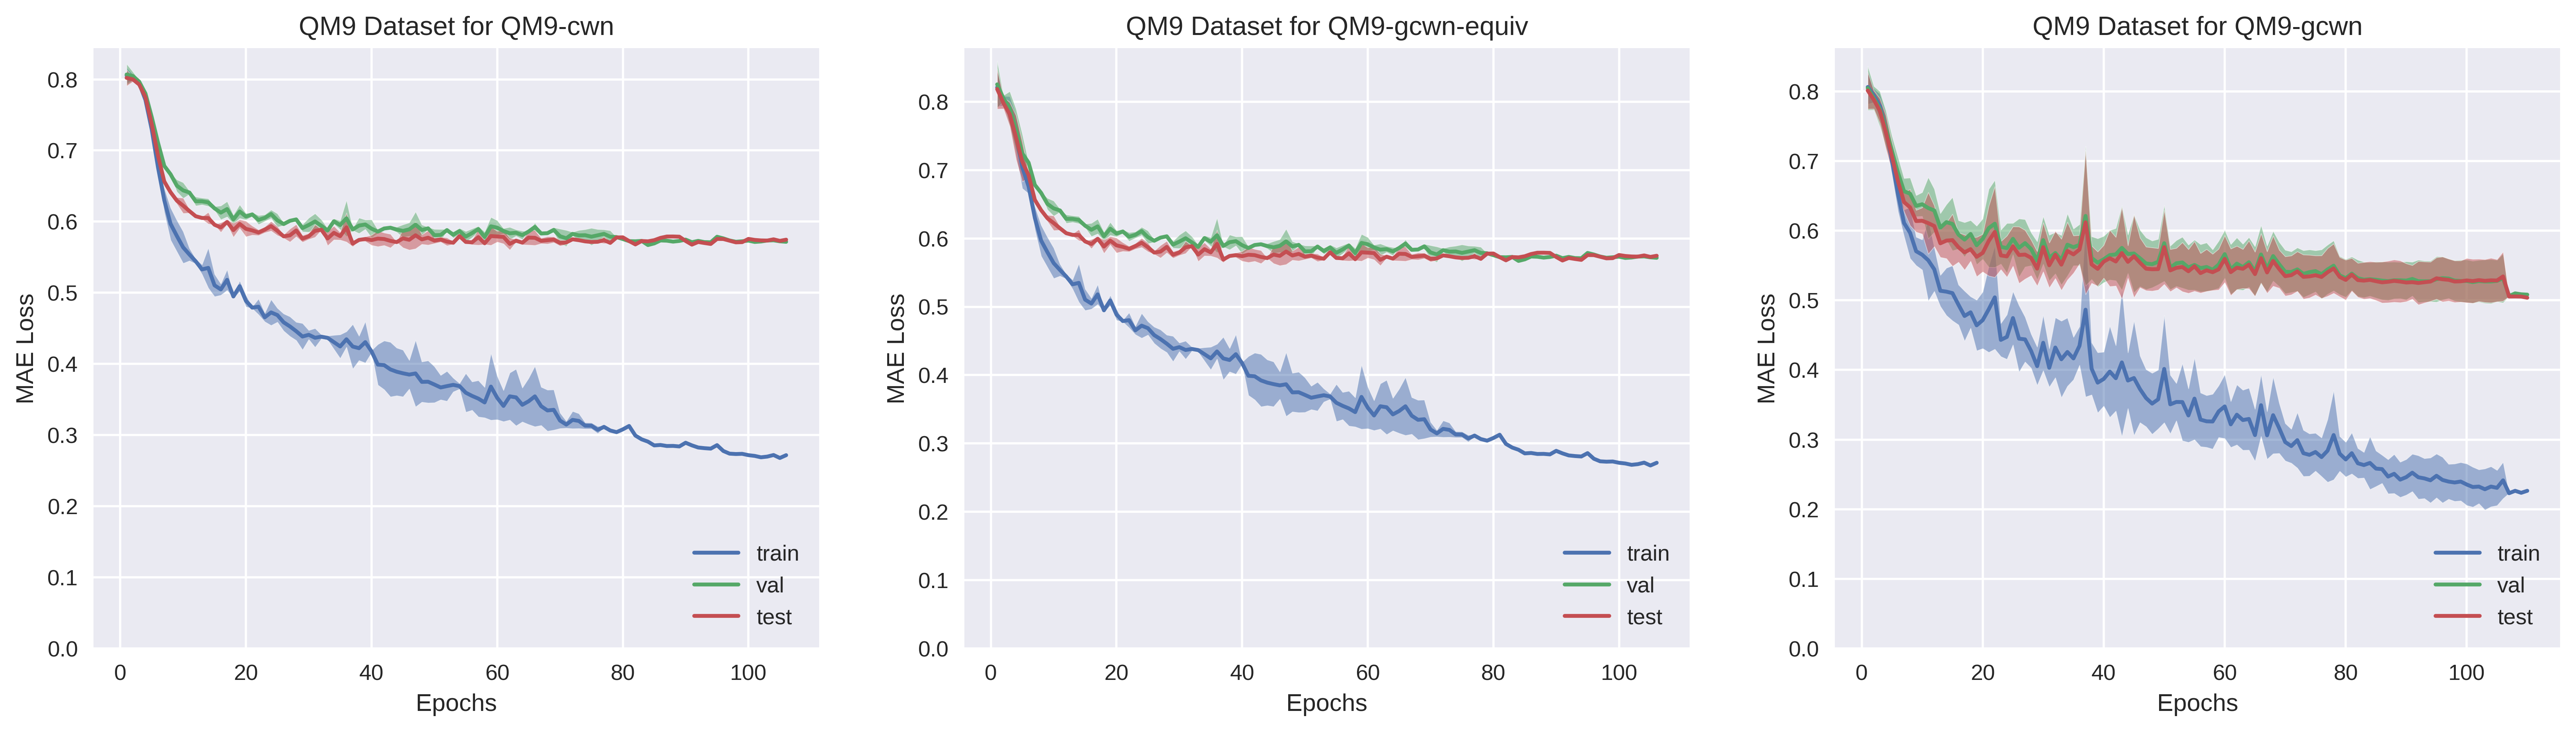

In [287]:
plt.style.use("seaborn")
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), dpi=400)
# ax[0]: train
model = "QM9-cwn"
times = [i for i in range(1, mean_std_curves[model]["train"][0].shape[0] + 1)]

for i, model in enumerate(mean_std_curves):
    times = [i for i in range(1, mean_std_curves[model]["train"][0].shape[0] + 1)]
    for split in mean_std_curves[model]:
        ax[i].plot(times, mean_std_curves[model][split][0], label=split)
        ax[i].fill_between(times, mean_std_curves[model][split][1], mean_std_curves[model][split][2], alpha=0.5)
        ax[i].set_title(f"QM9 Dataset for {model}")
        ax[i].set_xlabel("Epochs")
        ax[i].set_ylabel("MAE Loss")
        ax[i].set_ylim(bottom=0.0)
        ax[i].legend(loc=4)

# ax[0].plot(times, mean_std_curves[model]["train"][0], label="CWN")
# ax[0].fill_between(times, mean_std_curves[model]["train"][1], mean_std_curves[model]["train"][2], alpha=0.5)

# model = "QM9-gcwn"
# times = [i for i in range(1, mean_std_curves[model]["train"][0].shape[0] + 1)]
# ax[0].plot(times, mean_std_curves[model]["train"][0], label="GCWN-INV")
# ax[0].fill_between(times, mean_std_curves[model]["train"][1], mean_std_curves[model]["train"][2], alpha=0.5)

# model = "QM9-gcwn-equiv"
# times = [i for i in range(1, mean_std_curves[model]["train"][0].shape[0] + 1)]
# ax[0].plot(times, mean_std_curves[model]["train"][0], label="GCWN-EQUIV")
# ax[0].fill_between(times, mean_std_curves[model]["train"][1], mean_std_curves[model]["train"][2], alpha=0.5)

# ax[0].fill_between(times, train_mean - train_std, train_mean + train_std, alpha=0.5)
# ax[0].errorbar(gaps, irm_train, yerr=irm_train_se, label='IRMv1')
# ax[0].plot(gaps, [1/i for i in gaps], color='orange', linestyle='-', label='Random')

# ax[0].set_title("Train QM9 Dataset ")
# ax[0].set_xlabel("Number of outcomes $k\in\{2,\dots,10\}$")
# ax[0].set_ylabel("Train MAE Loss")
# ax[0].set_ylim(bottom=0.0)
# ax[0].legend(loc=4)

# ax[1]: test
# ax[1].errorbar(gaps, erm_test, yerr=erm_test_se, label='ERM')
# ax[1].errorbar(gaps, irm_test, yerr=irm_test_se, label='IRMv1')
# ax[1].plot(gaps, [1/i for i in gaps], color='orange', linestyle='-', label='Random')
# # ax[1].axvline(0.1, color='gray', linestyle='--', label='$|p_1 - p_2|$')
# ax[1].set_title("Test ($\eta_\mathrm{test} = 0.25, p_\mathrm{test} = 0.9, \mathrm{epochs} = 500$)")
# ax[1].set_xlabel("Number of outcomes $k\in\{2,\dots,10\}$")
# ax[1].set_ylabel("Accuracy")
# ax[1].set_ylim((0.0, 1.0))
# ax[1].legend(loc=1)
# plt.savefig(f"q3_plot_{style}.png", bbox_inches='tight')

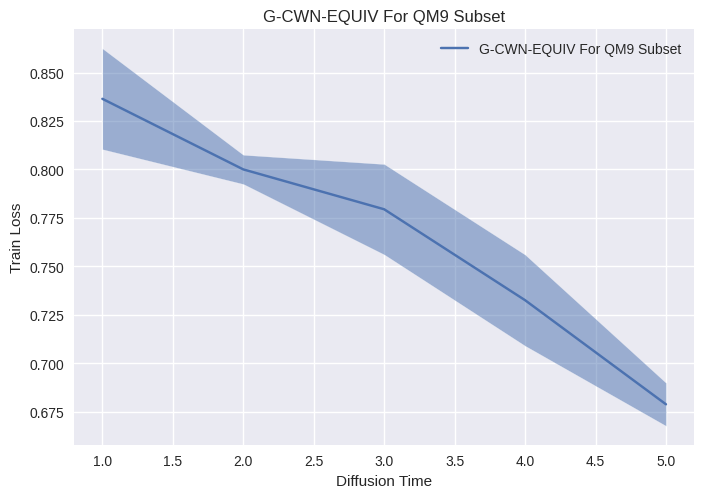

In [149]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import torch

def agg_results(res):
    res = np.array(res)
    mean = np.mean(res, axis=0)
    std = np.std(res, axis=0)
    return mean, std

data = torch.tensor(curves["train"])
# times = torch.arange(1, len(data)+1)
times = [i for i in range(1, len(data)+1)]
times = np.array(times)

# plt.figure(figsize=(8, 6), dpi=200)
plt.figure(dpi=100)

plt.plot(times, train_mean, label="G-CWN-EQUIV For QM9 Subset")
plt.fill_between(times, train_mean - train_std, np.clip(train_mean + train_std, 0.0, 1.0), alpha=0.5)

# plt.plot(times, sheaf_mean_test, label="Sheaf Diffusion (d=1)")
# plt.fill_between(times, sheaf_mean_test - sheaf_std_test, np.clip(sheaf_mean_test + sheaf_std_test, 0.0, 1.0), alpha=0.5)

# plt.plot(times, sheaf_mean_test, label="Sheaf Diffusion (d=1)")
# plt.fill_between(times, sheaf_mean_test - sheaf_std_test, np.clip(sheaf_mean_test + sheaf_std_test, 0.0, 1.0), alpha=0.5)

# plt.plot(times, oracle_mean_test, label="Oracle Sheaf Diffusion (d=1)")
# plt.fill_between(times, oracle_mean_test - oracle_std_test, oracle_mean_test + oracle_std_test, alpha=0.5)

plt.legend()
plt.title(fr"G-CWN-EQUIV For QM9 Subset")
plt.xlabel('Diffusion Time')
plt.ylabel('Train Loss')
# plt.savefig("biartite_test.pdf", bbox_inches='tight')
plt.show()

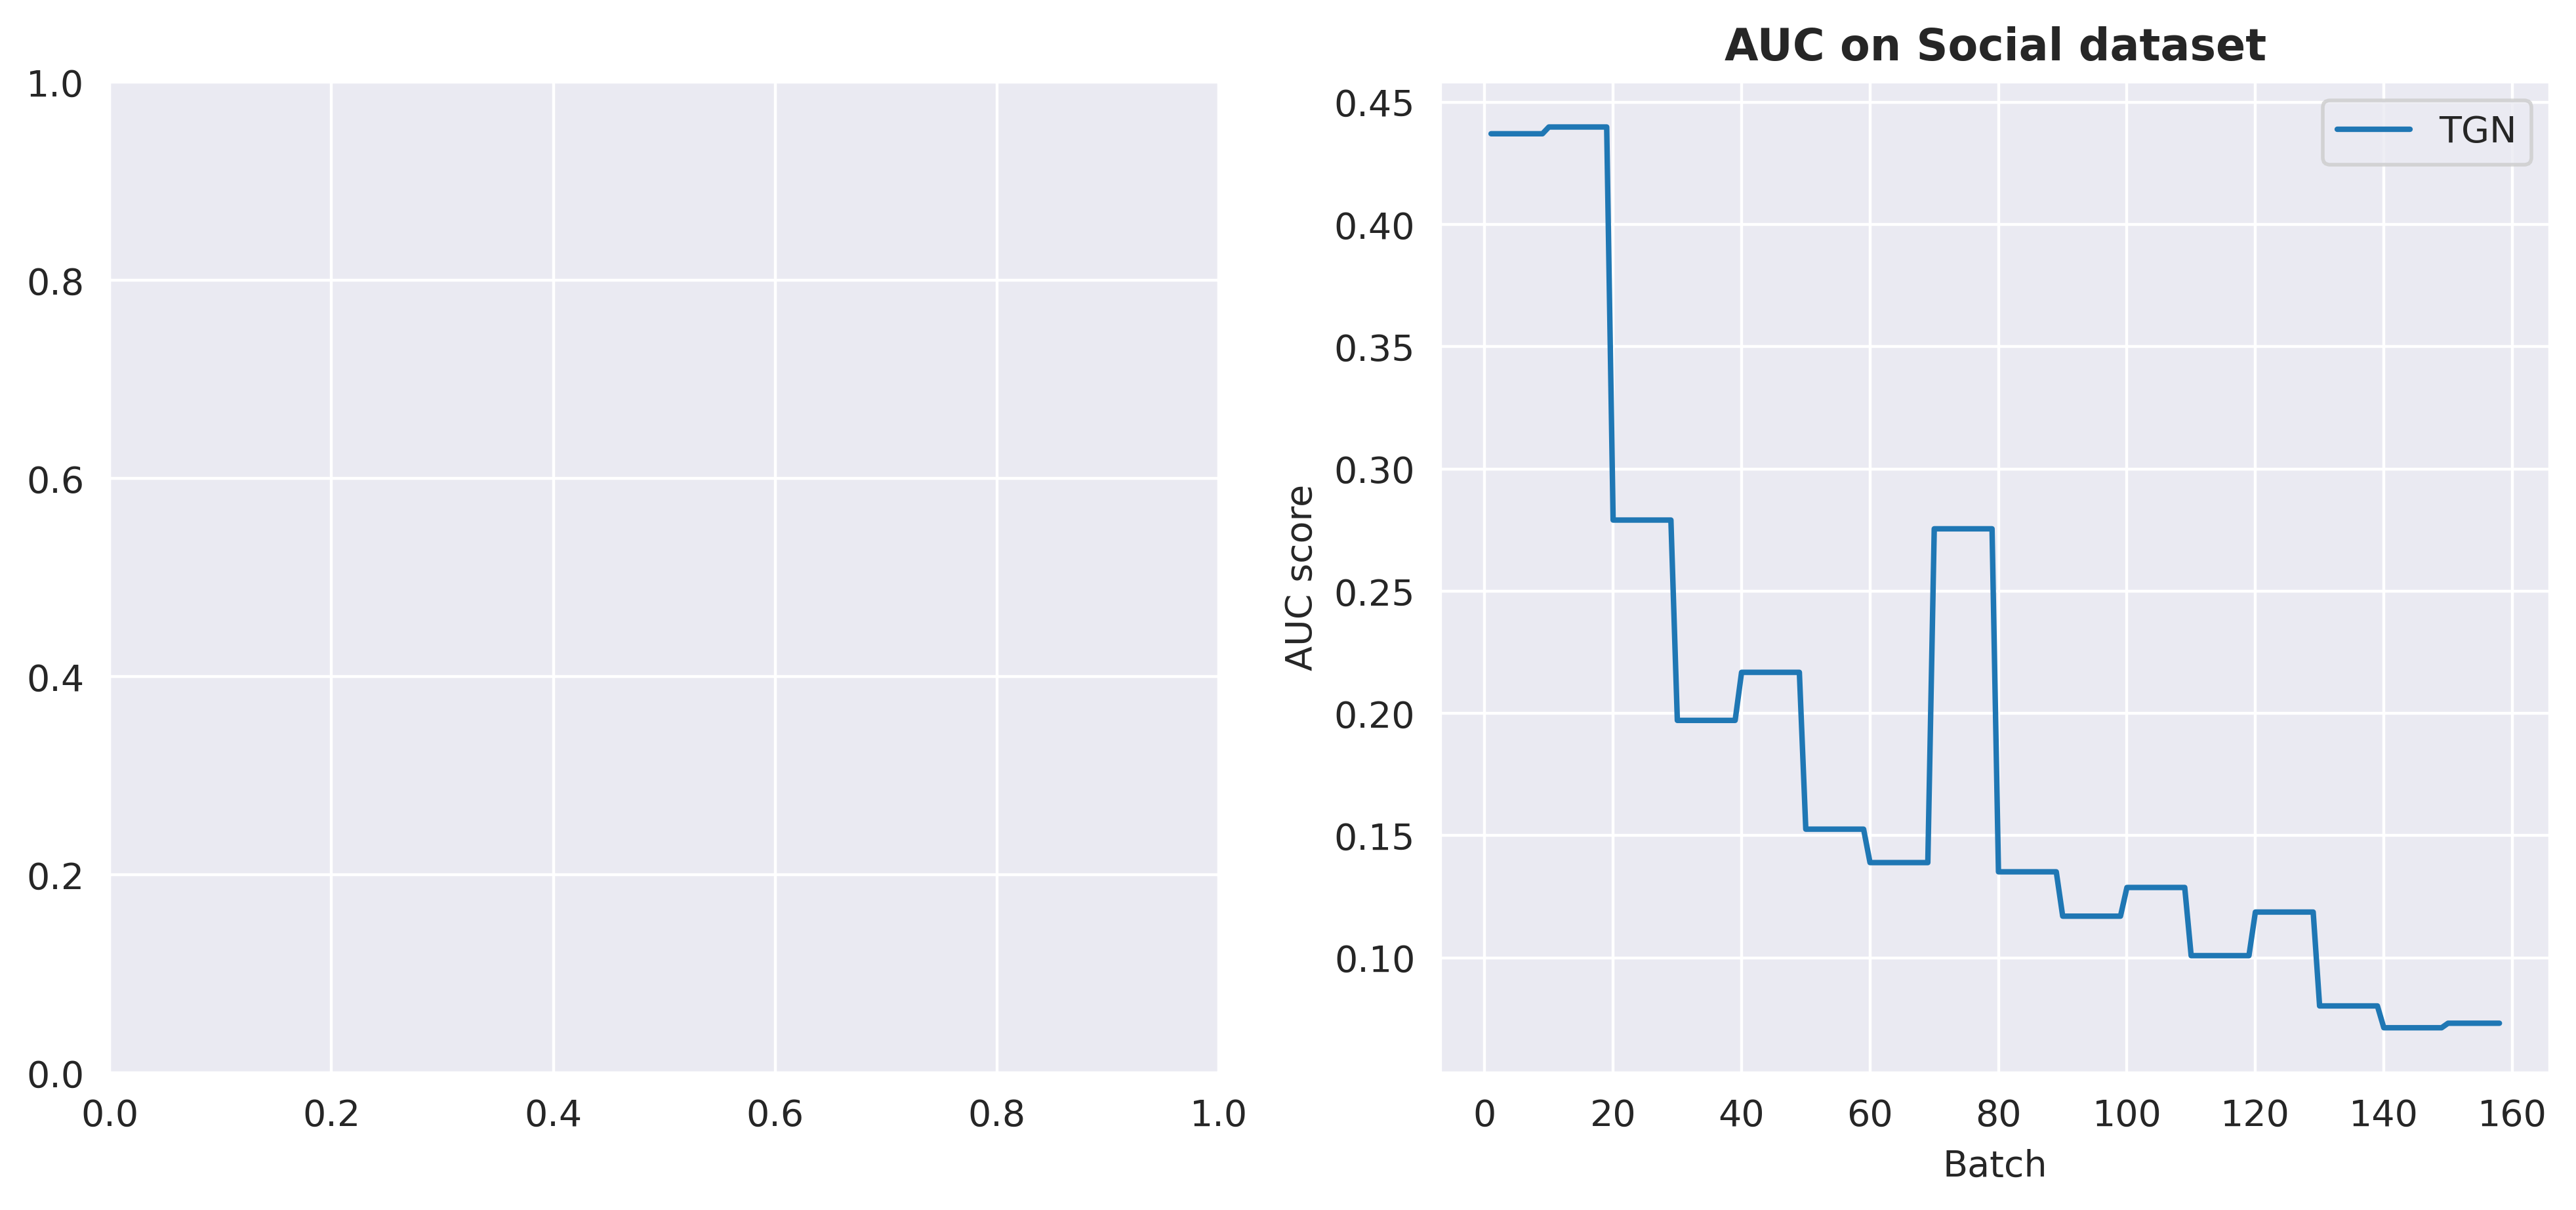

In [38]:
# create plot for curves
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
# avg_tgn = np.convolve(aucs_dict['TGN'][0], weights, 'valid')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=400)
plt.plot(np.linspace(1, len(data) , len(data)),  data, label='TGN')
plt.title('AUC on Social dataset', fontweight='bold')
plt.xlabel('Batch')
plt.ylabel('AUC score')
plt.legend()
plt.show()

In [ ]:
import seaborn as sns

window = 100
weights = np.repeat(1.0, window)/window
fig, axs = plt.subplots(1,2,figsize=(10,4),facecolor=(1,1,1))
avg_tgn = np.convolve(aucs_dict['TGN'][3], weights, 'valid')
axs[0].plot(np.linspace(1, len(avg_tgn) , len(avg_tgn)),  avg_tgn, label='TGN')
avg_sage = np.convolve(aucs_dict['SAGE'][2], weights, 'valid')
axs[0].plot(np.linspace(1, len(avg_sage) , len(avg_sage)),  avg_sage, label='SAGE')
avg_tgat = np.convolve(aucs_dict['TGAT'][5], weights, 'valid')
axs[0].plot(np.linspace(1, len(avg_tgat) , len(avg_tgat)),  avg_tgat, label='TGAT')
axs[0].set_title('AUC', fontweight='bold')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('AUC score')
axs[0].legend()

avg_tgn_p = np.convolve(p_dict['TGN'][3], weights, 'valid')
axs[1].plot(np.linspace(1, len(avg_tgn_p) , len(avg_tgn)),  avg_tgn_p, label='TGN')
avg_sage_p = np.convolve(p_dict['SAGE'][2], weights, 'valid')
axs[1].plot(np.linspace(1, len(avg_sage_p) , len(avg_sage_p)),  avg_sage_p, label='SAGE')
avg_tgat_p = np.convolve(p_dict['TGAT'][5], weights, 'valid')
plt.plot(np.linspace(1, len(avg_tgat) , len(avg_tgat_p)),  avg_tgat_p, label='TGAT')
axs[1].set_title('Precision', fontweight='bold')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Precision score')


plt.suptitle('Reddit', fontsize=16, fontweight='bold')
plt.tight_layout()
sns.set()